In [1]:
import pandas as pd
import numpy as np
import warnings
import os
from functools import reduce
warnings.filterwarnings(action='ignore')

import seaborn as sns

sns.set_palette("pastel")
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

sns.set(rc = {'figure.figsize':(15,7)})

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

In [2]:
def get_season(x):
    season = ''
    if (x == 1) or (x == 2) or (x == 12):
        season = 'winter'
    elif (x == 3) or (x == 4) or (x == 5):
        season = 'spring'
    elif (x == 6) or (x == 7) or (x == 8):
        season = 'summer'
    elif (x == 9) or (x == 10) or (x == 11):
        season = 'fall'
    else:
        season = ''
    return season

**Notation**
- 한식과 마트/수퍼마켓의 비율이 카드 사용량과 사용횟수 모두 압도적으로 많음
- 배달의 상관계수가 높긴 하지만 다른 품목에 비해서 상위권은 아님
- 상관계수가 많은 순서대로만 살펴보자면 쓰레기 배출량과 쓰레기 배출량 간 상관계수 패턴보다 결제건수와 결제 금액에 따른 상관계수 패턴을 좀 더 주의해서 봐야 할 것 같다. => 그러나, 대부분 0.9로 대동소이
- 카드 결제건수 -> 마트/슈퍼마켓, 카드 결제금액 -> 한식(아시아음식이 결제건수에 비해 상위권)이 가장 상관계수가 많음

In [3]:
waste = pd.read_csv('01_제공데이터/01_음식물쓰레기_FOOD_WASTE.CSV',encoding='cp949')

waste['base_date'] = pd.to_datetime(waste['base_date'])
waste['month'] = waste['base_date'].dt.month
waste['season'] = waste['month'].apply(lambda x: get_season(x)).astype('category')

In [4]:
card = pd.read_csv('01_제공데이터/04_음식관련 카드소비_CARD_SPENDING.CSV',encoding='cp949')

card['base_date'] = pd.to_datetime(card['base_date'])
card['month'] = card['base_date'].dt.month
card['season'] = card['month'].apply(lambda x: get_season(x)).astype('category')

In [5]:
card.head()

,base_date,city,emd_cd,emd_nm,mct_cat_cd,mct_cat_nm,use_cnt,use_amt,month,season
0,2018-01-06,제주시,50110650,연동,C00100,한식,3643,127777300,1,winter
1,2018-01-09,제주시,50110650,연동,C00500,패스트푸드,432,6711675,1,winter
2,2018-01-15,제주시,50110650,연동,C01200,농축수산물,236,16089579,1,winter
3,2018-01-15,제주시,50110650,연동,A00200,마트/슈퍼마켓,4031,121979867,1,winter
4,2018-01-20,제주시,50110650,연동,C01000,식품,633,30410674,1,winter


In [6]:
waste.head()

,base_date,city,emd_cd,emd_nm,em_area_cd,em_cnt,em_g,pay_amt,month,season
0,2018-01-01,제주시,50110670,외도동,W6X062,2,15500,464,1,winter
1,2018-01-01,제주시,50110630,아라동,W6XA97,25,59800,1787,1,winter
2,2018-01-01,제주시,50110630,아라동,W6XA96,8,25350,758,1,winter
3,2018-01-01,제주시,50110630,아라동,W6XA95,12,30000,898,1,winter
4,2018-01-01,제주시,50110630,아라동,W6XA94,14,44050,1317,1,winter


In [7]:
waste.groupby(['base_date'])['em_cnt','em_g','pay_amt'].sum().corr()

,em_cnt,em_g,pay_amt
em_cnt,1.000000,0.891084,0.867387
em_g,0.891084,1.000000,0.970358
pay_amt,0.867387,0.970358,1.000000


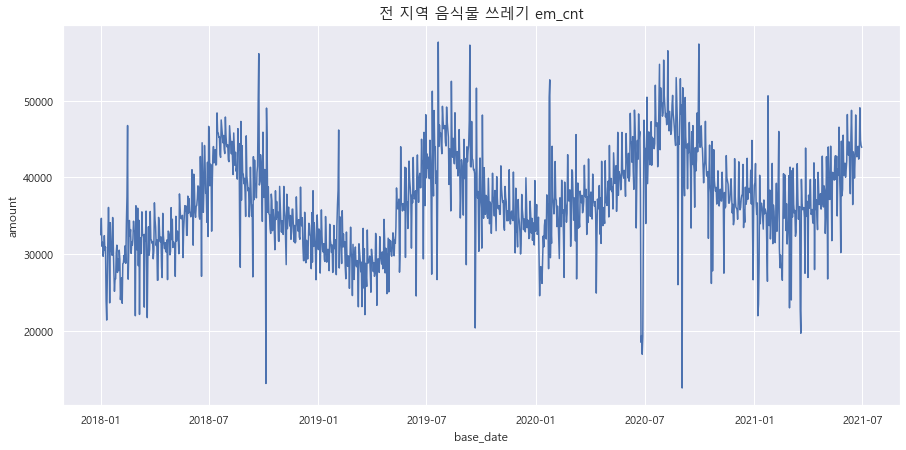

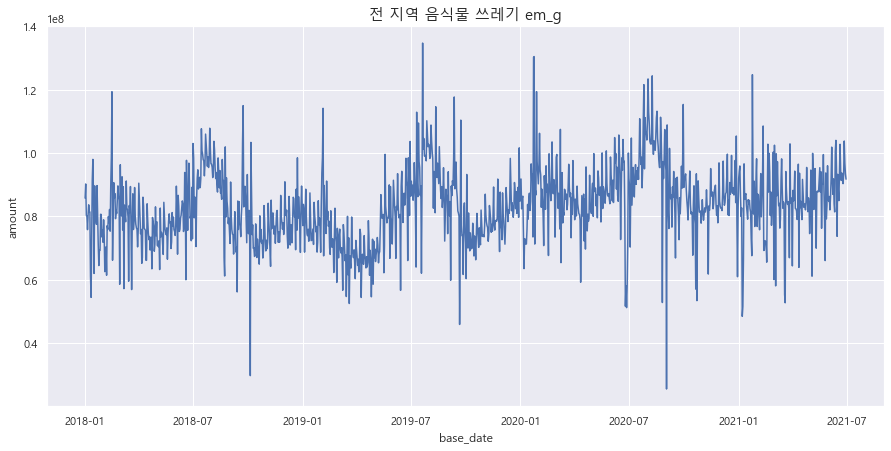

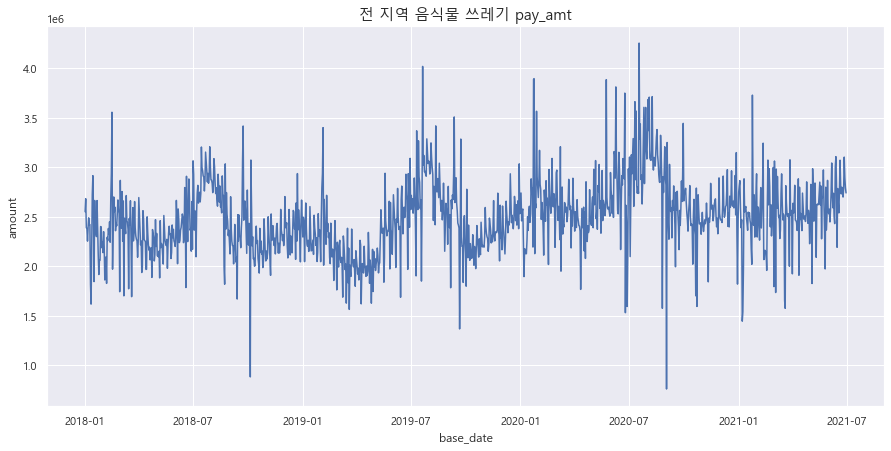

In [8]:
total_waste = waste.groupby(['base_date'])['em_cnt','em_g','pay_amt'].sum().stack().reset_index()
total_waste.columns = ['base_date','em','amount']

for em in total_waste['em'].unique():
    sns.lineplot(data=total_waste[total_waste['em'] == em],x='base_date',y='amount')
    plt.title('전 지역 음식물 쓰레기 {}'.format(em), fontsize=15)
    plt.show()

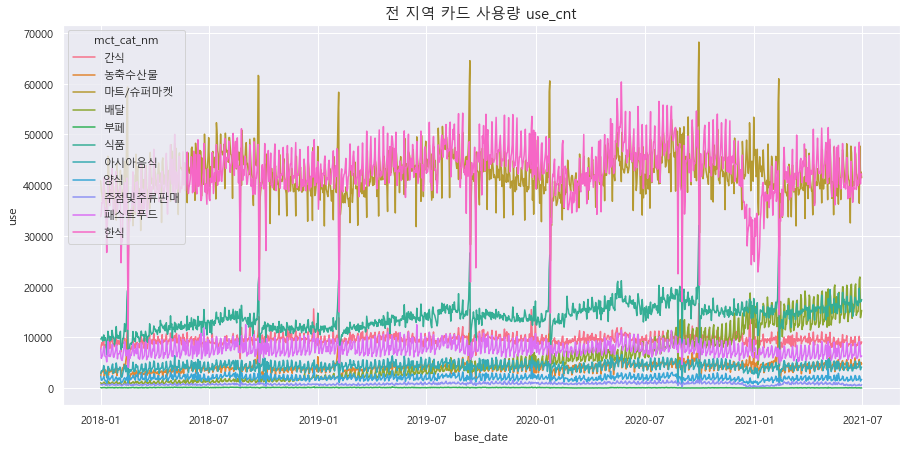

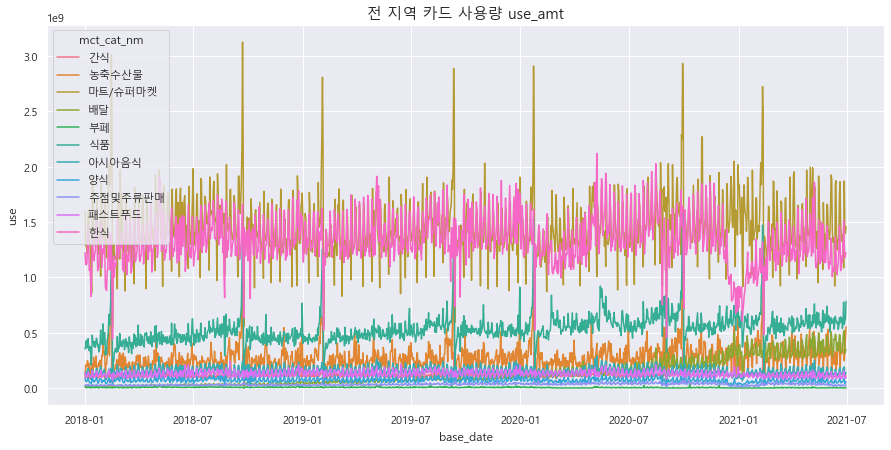

In [9]:
total_card = card.groupby(['base_date','mct_cat_nm'])['use_cnt', 'use_amt'].sum().stack().reset_index()
total_card.columns = ['base_date','mct_cat_nm','card','use']

for c in total_card['card'].unique():
    sns.lineplot(data=total_card[total_card['card'] == c],x='base_date',y='use', hue='mct_cat_nm')
    plt.title('전 지역 카드 사용량 {}'.format(c), fontsize=15)
    plt.show()

# 배출량, 배출횟수, 결제건수, 결제금액 상관관계(월별 집계)
- 음식물 쓰레기 배출량과 배출건수 모두 카드 결제건수와 금액과 높은 상관관계가 있다는 것을 확인

In [19]:
em_waste = waste.groupby(['base_date','month','emd_nm'])['em_g','em_cnt'].sum().reset_index()
em_waste = em_waste.groupby(['month','emd_nm'])['em_g','em_cnt'].mean().reset_index()
total_card = card.groupby(['base_date','month','emd_nm','mct_cat_nm'])['use_cnt','use_amt'].sum().reset_index()
total_card = total_card.groupby(['month','emd_nm','mct_cat_nm'])['use_cnt','use_amt'].mean().stack().reset_index()

total_card.columns = ['month','emd_nm','mct_cat_nm','card','use']
total_card_pivot = total_card.pivot_table(index=['month','emd_nm'],columns=['card'], values=['use'],aggfunc='sum').reset_index()

total_card_pivot.columns = list(total_card_pivot.columns.get_level_values(0)[:2]) + list(total_card_pivot.columns.get_level_values(1)[2:])

card_em = pd.merge(em_waste, total_card_pivot, on=['month','emd_nm'],how='left').set_index(['month','emd_nm'])
card_em.corr().style.background_gradient(cmap='summer_r')

,em_g,em_cnt,use_amt,use_cnt
em_g,1.000000,0.985589,0.959995,0.962268
em_cnt,0.985589,1.000000,0.956948,0.965324
use_amt,0.959995,0.956948,1.000000,0.997627
use_cnt,0.962268,0.965324,0.997627,1.000000


In [49]:
# 행정동 간 use_amt, use_cnt, em_g, em_cnt 상관관계
em_waste = waste.groupby(['base_date','emd_nm'])['em_g','em_cnt'].sum().reset_index()
em_waste = em_waste.groupby(['emd_nm'])['em_g','em_cnt'].mean().reset_index()
total_mct = card.groupby(['base_date','emd_nm','mct_cat_nm'])['use_cnt','use_amt'].sum().reset_index()
total_mct = total_mct.groupby(['emd_nm'])['use_cnt','use_amt'].mean().reset_index()
waste_card = pd.merge(em_waste, total_mct, on=['emd_nm'],how='left').set_index(['emd_nm'])
waste_card.T.corr().style.background_gradient(cmap='summer_r')

# 중앙동이 그나마 상관관계가 낮게 나옴

emd_nm,건입동,구좌읍,남원읍,노형동,대륜동,대정읍,대천동,도두동,동홍동,봉개동,삼도1동,삼도2동,삼양동,서홍동,성산읍,송산동,아라동,안덕면,알수없음,애월읍,연동,영천동,예래동,오라동,외도동,용담1동,용담2동,이도1동,이도2동,이호동,일도1동,일도2동,정방동,조천읍,중문동,중앙동,천지동,표선면,한경면,한림읍,화북동,효돈동
emd_nm,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
건입동,1.000000,0.998927,0.999181,1.000000,0.999888,0.999538,0.999989,0.999513,0.999593,0.999960,0.999754,0.999970,0.999748,0.999762,0.999116,0.994550,0.999905,0.999138,0.999723,0.992254,0.999997,0.996782,0.999975,0.999822,0.999926,0.998991,0.999929,0.998721,0.999792,0.999462,0.999346,0.998855,0.973866,0.997886,0.997463,0.941645,0.982209,0.999585,0.999532,0.999933,0.999295,0.998668
구좌읍,0.998927,1.000000,0.996234,0.998884,0.999509,0.997058,0.999134,0.996996,0.997199,0.999303,0.997655,0.998537,0.997635,0.999699,0.996097,0.988655,0.999470,0.999988,0.999740,0.996942,0.999043,0.992000,0.999230,0.999623,0.998289,0.995839,0.998306,0.995308,0.997776,0.996871,0.996599,0.995567,0.962303,0.999825,0.993096,0.925046,0.972459,0.999847,0.999876,0.998323,0.996484,0.999986
남원읍,0.999181,0.996234,1.000000,0.999217,0.998462,0.999949,0.998979,0.999957,0.999929,0.998776,0.999832,0.999465,0.999838,0.998060,0.999999,0.997955,0.998528,0.996639,0.997952,0.986413,0.999073,0.999210,0.998869,0.998240,0.999599,0.999990,0.999591,0.999949,0.999798,0.999970,0.999991,0.999973,0.982261,0.994438,0.999527,0.954497,0.989005,0.997599,0.997474,0.999583,0.999996,0.995761
노형동,1.000000,0.998884,0.999217,1.000000,0.999874,0.999565,0.999984,0.999541,0.999618,0.999951,0.999774,0.999976,0.999768,0.999742,0.999154,0.994645,0.999892,0.999100,0.999701,0.992140,0.999994,0.996855,0.999968,0.999805,0.999937,0.999031,0.999940,0.998767,0.999811,0.999492,0.999378,0.998898,0.974072,0.997826,0.997527,0.941951,0.982380,0.999558,0.999504,0.999943,0.999329,0.998621
대륜동,0.999888,0.999509,0.998462,0.999874,1.000000,0.998971,0.999947,0.998934,0.999053,0.999982,0.999310,0.999741,0.999299,0.999977,0.998374,0.992877,0.999999,0.999648,0.999964,0.994003,0.999923,0.995469,0.999969,0.999993,0.999631,0.998206,0.999639,0.997852,0.999375,0.998859,0.998692,0.998026,0.970354,0.998748,0.996284,0.936497,0.979286,0.999904,0.999878,0.999647,0.998621,0.999329
대정읍,0.999538,0.997058,0.999949,0.999565,0.998971,1.000000,0.999384,1.000000,0.999998,0.999224,0.999966,0.999744,0.999969,0.998638,0.999932,0.997259,0.999024,0.997415,0.998547,0.988020,0.999457,0.998758,0.999298,0.998788,0.999834,0.999894,0.999829,0.999796,0.999950,0.999997,0.999983,0.999847,0.980318,0.995450,0.999166,0.951439,0.987463,0.998247,0.998140,0.999823,0.999974,0.996639
대천동,0.999989,0.999134,0.998979,0.999984,0.999947,0.999384,1.000000,0.999355,0.999447,0.999991,0.999639,0.999922,0.999631,0.999854,0.998906,0.994047,0.999959,0.999323,0.999823,0.992828,0.999998,0.996393,0.999997,0.999900,0.999857,0.998768,0.999862,0.998472,0.999685,0.999297,0.999164,0.998618,0.972784,0.998181,0.997116,0.940047,0.981313,0.999710,0.999665,0.999867,0.999107,0.998900
도두동,0.999513,0.996996,0.999957,0.999541,0.998934,1.000000,0.999355,1.000000,0.999996,0.999192,0.999959,0.999725,0.999962,0.998595,0.999941,0.997319,0.998988,0.997356,0.998503,0.987895,0.999430,0.998798,0.999267,0.998748,0.999819,0.999906,0.999813,0.999812,0.999941,0.999999,0.999988,0.999861,0.980478,0.995373,0.999198,0.951688,0.987590,0.998199,0.998091,0.999808,0.999980,0.996572
동홍동,0.999593,0.997199,0.999929,0.999618,0.999053,0.999998,0.999447,0.999996,1.000000,0.999295,0.999980,0.999784,0.999982,0.998733,0.999909,0.997120,0.999104,0.997546,0.998645,0.988304,0.999516,0.998664,0.999366,0.998877,0.999866,0.999866,0.999861,0.999757,0.999967,0.999991,0.999971,0.999813,0.979951,0.995625,0.999088,0.950868,0.987169,0.998355,0.998252,0.999857,0.999959,0.996789


# 쓰레기 배출량
(상관계수 절대값0.9 이상)
- 쓰레기 배출량과 카드 결제건수 : 마트/슈퍼마켓, 간식, 패스트푸드, 한식, 아시아음식, 주점및주류판매, 배달, 양식
- 쓰레기 배출량과 카드 결제금액 : 한식, 아시아음식, 간식, 패스트푸드, 마트/슈퍼마켓, 주점및주류판매, 양식, 배달, 농축수산물

In [20]:
# 쓰레기 배출량과 카드 카테고리별 결제 건수 사이의 월별 상관관계
emg_waste = waste.groupby(['base_date','month','emd_nm'])['em_g'].sum().reset_index() # 일평균 쓰레기 배출량
emg_waste = emg_waste.groupby(['month','emd_nm'])['em_g'].mean().reset_index() # 월평균 쓰레기 배출량
total_mct = card.groupby(['base_date','month','emd_nm','mct_cat_nm'])['use_cnt'].sum().reset_index() # 일평균 모든 종류의 유동인구
total_mct = total_mct.groupby(['month','emd_nm','mct_cat_nm'])['use_cnt'].mean().reset_index() # 일평균 모든 종류의 유동인구

total_mct_pivot = total_mct.pivot_table(index=['month','emd_nm'],columns = 'mct_cat_nm',values='use_cnt', aggfunc='sum').reset_index()

card_gcnt = pd.merge(emg_waste, total_mct_pivot, on=['month','emd_nm'],how='left').set_index(['month','emd_nm'])
card_gcnt.corr().style.background_gradient(cmap='summer_r')

,em_g,간식,농축수산물,마트/슈퍼마켓,배달,부페,식품,아시아음식,양식,주점및주류판매,패스트푸드,한식
em_g,1.000000,0.957751,0.856393,0.964289,0.922827,0.819261,0.810580,0.951579,0.913365,0.940637,0.957534,0.954076
간식,0.957751,1.000000,0.870278,0.973824,0.940667,0.839493,0.881904,0.990025,0.953023,0.946601,0.992858,0.991450
농축수산물,0.856393,0.870278,1.000000,0.816774,0.799043,0.779852,0.733804,0.860541,0.820512,0.818602,0.863943,0.864892
마트/슈퍼마켓,0.964289,0.973824,0.816774,1.000000,0.950128,0.815811,0.826442,0.974156,0.913522,0.950550,0.971316,0.974247
배달,0.922827,0.940667,0.799043,0.950128,1.000000,0.781206,0.798146,0.942068,0.856003,0.960764,0.925056,0.949775
부페,0.819261,0.839493,0.779852,0.815811,0.781206,1.000000,0.816676,0.844578,0.770383,0.812941,0.847692,0.846473
식품,0.810580,0.881904,0.733804,0.826442,0.798146,0.816676,1.000000,0.905289,0.844040,0.833728,0.903985,0.897821
아시아음식,0.951579,0.990025,0.860541,0.974156,0.942068,0.844578,0.905289,1.000000,0.936334,0.954931,0.993882,0.997215
양식,0.913365,0.953023,0.820512,0.913522,0.856003,0.770383,0.844040,0.936334,1.000000,0.872197,0.949090,0.934573
주점및주류판매,0.940637,0.946601,0.818602,0.950550,0.960764,0.812941,0.833728,0.954931,0.872197,1.000000,0.939633,0.967280


In [21]:
# 상관관계의 절대값이 0.9 이상인 품목
card_gcnt.corr()[(card_gcnt.corr()['em_g']>0.9)|(card_gcnt.corr()['em_g']<-0.9)][['em_g']].sort_values(by='em_g',ascending=False)[1:].T

,마트/슈퍼마켓,간식,패스트푸드,한식,아시아음식,주점및주류판매,배달,양식
em_g,0.964289,0.957751,0.957534,0.954076,0.951579,0.940637,0.922827,0.913365


In [22]:
# 쓰레기 배출량과 카드 카테고리별 결제 금액 사이의 월별 상관관계

emg_waste = waste.groupby(['base_date','month','emd_nm'])['em_g'].sum().reset_index() # 월평균 쓰레기 배출량
emg_waste = emg_waste.groupby(['month','emd_nm'])['em_g'].mean().reset_index() # 월평균 쓰레기 배출량
total_mct = card.groupby(['base_date','month','emd_nm','mct_cat_nm'])['use_amt'].sum().reset_index() # 일종합
total_mct = total_mct.groupby(['month','emd_nm','mct_cat_nm'])['use_amt'].mean().reset_index() # 월평균

total_mct_pivot = total_mct.pivot_table(index=['month','emd_nm'],columns = 'mct_cat_nm',values='use_amt', aggfunc='sum').reset_index()

card_gamt = pd.merge(emg_waste, total_mct_pivot, on=['month','emd_nm'],how='left').set_index(['month','emd_nm'])
card_gamt.corr().style.background_gradient(cmap='summer_r')

,em_g,간식,농축수산물,마트/슈퍼마켓,배달,부페,식품,아시아음식,양식,주점및주류판매,패스트푸드,한식
em_g,1.000000,0.953327,0.918758,0.943890,0.921873,0.355905,0.816402,0.955894,0.927123,0.935178,0.949644,0.958067
간식,0.953327,1.000000,0.923473,0.953395,0.940544,0.356973,0.892503,0.985462,0.964174,0.941214,0.989813,0.987183
농축수산물,0.918758,0.923473,1.000000,0.867985,0.870538,0.382613,0.857847,0.909517,0.858145,0.886484,0.915146,0.921855
마트/슈퍼마켓,0.943890,0.953395,0.867985,1.000000,0.930695,0.312108,0.816781,0.967546,0.936460,0.924297,0.958285,0.954281
배달,0.921873,0.940544,0.870538,0.930695,1.000000,0.325896,0.800708,0.951814,0.890906,0.966001,0.915207,0.948651
부페,0.355905,0.356973,0.382613,0.312108,0.325896,1.000000,0.339605,0.352060,0.324851,0.342827,0.353976,0.368116
식품,0.816402,0.892503,0.857847,0.816781,0.800708,0.339605,1.000000,0.894384,0.846261,0.824581,0.905891,0.898419
아시아음식,0.955894,0.985462,0.909517,0.967546,0.951814,0.352060,0.894384,1.000000,0.954942,0.961329,0.985638,0.996076
양식,0.927123,0.964174,0.858145,0.936460,0.890906,0.324851,0.846261,0.954942,1.000000,0.897594,0.967252,0.952255
주점및주류판매,0.935178,0.941214,0.886484,0.924297,0.966001,0.342827,0.824581,0.961329,0.897594,1.000000,0.921015,0.965752


In [23]:
# 상관관계의 절대값이 0.9 이상인 품목
card_gamt.corr()[(card_gamt.corr()['em_g']>0.9)|(card_gamt.corr()['em_g']<-0.9)][['em_g']].sort_values(by='em_g',ascending=False)[1:].T

,한식,아시아음식,간식,패스트푸드,마트/슈퍼마켓,주점및주류판매,양식,배달,농축수산물
em_g,0.958067,0.955894,0.953327,0.949644,0.94389,0.935178,0.927123,0.921873,0.918758


# 쓰레기 배출건수
(상관계수 절대값0.9 이상)
- 쓰레기 배출건수와 카드 결제건수 : 마트/슈퍼마켓, 한식, 간식, 패스트푸드, 아시아음식, 주점및주류판매, 배달, 양식
- 쓰레기 배출건수와 카드 결제금액 : 한식, 아시아음식, 간식, 주점및주류판매, 패스트푸드, 마트/슈퍼마켓, 배달, 양식, 농축수산물

In [24]:
# 쓰레기 배출건수와 카드 카테고리별 결제건수 사이의 월별 상관관계

emg_waste = waste.groupby(['base_date','month','emd_nm'])['em_cnt'].sum().reset_index()
emg_waste = emg_waste.groupby(['month','emd_nm'])['em_cnt'].mean().reset_index()
total_mct = card.groupby(['base_date','month','emd_nm','mct_cat_nm'])['use_cnt'].sum().reset_index()
total_mct = total_mct.groupby(['month','emd_nm','mct_cat_nm'])['use_cnt'].mean().reset_index()

total_mct_pivot = total_mct.pivot_table(index=['month','emd_nm'],columns = 'mct_cat_nm',values='use_cnt', aggfunc='sum').reset_index()

card_cc = pd.merge(emg_waste, total_mct_pivot, on=['month','emd_nm'],how='left').set_index(['month','emd_nm'])
card_cc.corr().style.background_gradient(cmap='summer_r')

,em_cnt,간식,농축수산물,마트/슈퍼마켓,배달,부페,식품,아시아음식,양식,주점및주류판매,패스트푸드,한식
em_cnt,1.000000,0.959172,0.869023,0.968108,0.924123,0.824926,0.799541,0.956270,0.901515,0.955913,0.957162,0.960864
간식,0.959172,1.000000,0.870278,0.973824,0.940667,0.839493,0.881904,0.990025,0.953023,0.946601,0.992858,0.991450
농축수산물,0.869023,0.870278,1.000000,0.816774,0.799043,0.779852,0.733804,0.860541,0.820512,0.818602,0.863943,0.864892
마트/슈퍼마켓,0.968108,0.973824,0.816774,1.000000,0.950128,0.815811,0.826442,0.974156,0.913522,0.950550,0.971316,0.974247
배달,0.924123,0.940667,0.799043,0.950128,1.000000,0.781206,0.798146,0.942068,0.856003,0.960764,0.925056,0.949775
부페,0.824926,0.839493,0.779852,0.815811,0.781206,1.000000,0.816676,0.844578,0.770383,0.812941,0.847692,0.846473
식품,0.799541,0.881904,0.733804,0.826442,0.798146,0.816676,1.000000,0.905289,0.844040,0.833728,0.903985,0.897821
아시아음식,0.956270,0.990025,0.860541,0.974156,0.942068,0.844578,0.905289,1.000000,0.936334,0.954931,0.993882,0.997215
양식,0.901515,0.953023,0.820512,0.913522,0.856003,0.770383,0.844040,0.936334,1.000000,0.872197,0.949090,0.934573
주점및주류판매,0.955913,0.946601,0.818602,0.950550,0.960764,0.812941,0.833728,0.954931,0.872197,1.000000,0.939633,0.967280


In [25]:
# 상관관계의 절대값이 0.9 이상인 품목
card_cc.corr()[(card_cc.corr()['em_cnt']>0.9)|(card_cc.corr()['em_cnt']<-0.9)][['em_cnt']].sort_values(by='em_cnt',ascending=False)[1:].T

,마트/슈퍼마켓,한식,간식,패스트푸드,아시아음식,주점및주류판매,배달,양식
em_cnt,0.968108,0.960864,0.959172,0.957162,0.95627,0.955913,0.924123,0.901515


In [26]:
# 쓰레기 배출건수와 카드 카테고리별 결제 금액 사이의 월별 상관관계

emg_waste = waste.groupby(['base_date','month','emd_nm'])['em_cnt'].sum().reset_index()
emg_waste = emg_waste.groupby(['month','emd_nm'])['em_cnt'].mean().reset_index()
total_mct = card.groupby(['base_date','month','emd_nm','mct_cat_nm'])['use_amt'].sum().reset_index()
total_mct = total_mct.groupby(['month','emd_nm','mct_cat_nm'])['use_amt'].mean().reset_index()

total_mct_pivot = total_mct.pivot_table(index=['month','emd_nm'],columns = 'mct_cat_nm',values='use_amt', aggfunc='sum').reset_index()

card_camt = pd.merge(emg_waste, total_mct_pivot, on=['month','emd_nm'],how='left').set_index(['month','emd_nm'])
card_camt.corr().style.background_gradient(cmap='summer_r')

,em_cnt,간식,농축수산물,마트/슈퍼마켓,배달,부페,식품,아시아음식,양식,주점및주류판매,패스트푸드,한식
em_cnt,1.000000,0.952412,0.916423,0.935013,0.922415,0.359274,0.805671,0.957619,0.917406,0.946170,0.945204,0.962535
간식,0.952412,1.000000,0.923473,0.953395,0.940544,0.356973,0.892503,0.985462,0.964174,0.941214,0.989813,0.987183
농축수산물,0.916423,0.923473,1.000000,0.867985,0.870538,0.382613,0.857847,0.909517,0.858145,0.886484,0.915146,0.921855
마트/슈퍼마켓,0.935013,0.953395,0.867985,1.000000,0.930695,0.312108,0.816781,0.967546,0.936460,0.924297,0.958285,0.954281
배달,0.922415,0.940544,0.870538,0.930695,1.000000,0.325896,0.800708,0.951814,0.890906,0.966001,0.915207,0.948651
부페,0.359274,0.356973,0.382613,0.312108,0.325896,1.000000,0.339605,0.352060,0.324851,0.342827,0.353976,0.368116
식품,0.805671,0.892503,0.857847,0.816781,0.800708,0.339605,1.000000,0.894384,0.846261,0.824581,0.905891,0.898419
아시아음식,0.957619,0.985462,0.909517,0.967546,0.951814,0.352060,0.894384,1.000000,0.954942,0.961329,0.985638,0.996076
양식,0.917406,0.964174,0.858145,0.936460,0.890906,0.324851,0.846261,0.954942,1.000000,0.897594,0.967252,0.952255
주점및주류판매,0.946170,0.941214,0.886484,0.924297,0.966001,0.342827,0.824581,0.961329,0.897594,1.000000,0.921015,0.965752


In [27]:
# 상관관계의 절대값이 0.9 이상인 품목
card_camt.corr()[(card_camt.corr()['em_cnt']>0.9)|(card_camt.corr()['em_cnt']<-0.9)][['em_cnt']].sort_values(by='em_cnt',ascending=False)[1:].T

,한식,아시아음식,간식,주점및주류판매,패스트푸드,마트/슈퍼마켓,배달,양식,농축수산물
em_cnt,0.962535,0.957619,0.952412,0.94617,0.945204,0.935013,0.922415,0.917406,0.916423
